In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [2]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


## Figure S155

In [3]:
#################################
###    import Sorption data   ###
#################################

path = ''

filelist = ['../../data/ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx',
            '../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls',
           '../../data/ROS-037_composite/27C/19-0182-4_isotherm_27C-2021-12-24 14-41-16.xlsx',
            ]

# color list
name_and_color_dictionary = {'../../data/ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx':
                             {'color':'green', 'name':'ROS-037 powder'},
                             '../../data/ROS-037_composite/27C/19-0182-4_isotherm_27C-2021-12-24 14-41-16.xlsx':
                             {'color':'limegreen', 'name':'ROS-037 paper composite'},
                             '../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls':
                             {'color':'red', 'name':'cellulose'},
                             
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File ../../data/ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx read succesfull
File ../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls read succesfull
File ../../data/ROS-037_composite/27C/19-0182-4_isotherm_27C-2021-12-24 14-41-16.xlsx read succesfull


[]
[0, 158535]
0 158535
0
[]
[0, 39825]
0 39825
1
[]
[0, 75072]
0 75072
2
[0.54678898]


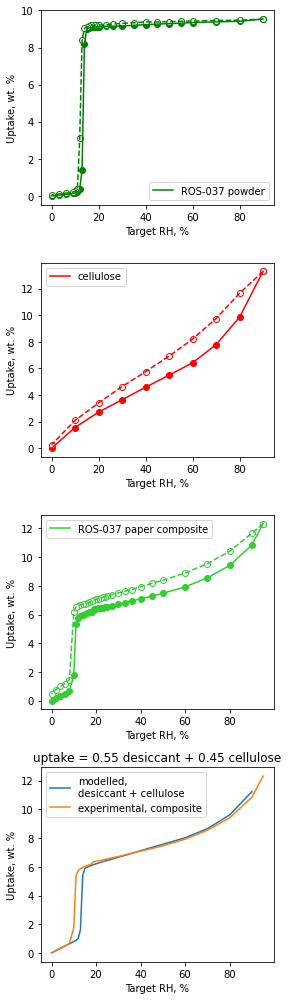

In [4]:
isotherm_data = []
def add_picture_WaterSorption_isotherm(Sorption_list, dpi, width, height):
    fig, ax = plt.subplots(4, 1, figsize=(4, 14))
    
    for m, Sorption in enumerate(Sorption_list):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
            print(m)
            ax[m].plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                     c=name_and_color_dictionary[Sorption.filename]['color'],
                     label=name_and_color_dictionary[Sorption.filename]['name'])
            ax[m].scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                        c=name_and_color_dictionary[Sorption.filename]['color'])
            ax[m].plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                     c=name_and_color_dictionary[Sorption.filename]['color'], 
                     linestyle='dashed')
            ax[m].scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                        facecolors='w', 
                        edgecolors=name_and_color_dictionary[Sorption.filename]['color'])
            ax[m].set_xlabel('Target RH, %')
            ax[m].set_ylabel('Uptake, wt. %')
            ax[m].legend()        
            isotherm_data.append([isotherm_RHtarget_ads, [i for i in isotherm_adsorption]])
    from scipy.optimize import curve_fit
    def func(x, a):
        return a * interpolate_desiccant(x) +  (1-a) * interpolate_cellulose(x)   
    
    from scipy import interpolate
    interpolate_desiccant = interpolate.interp1d(isotherm_data[0][0], isotherm_data[0][1])
    interpolate_cellulose = interpolate.interp1d(isotherm_data[1][0], isotherm_data[1][1])
    interpolate_composite = interpolate.interp1d(isotherm_data[2][0], isotherm_data[2][1])
    popt, pcov = curve_fit(func, np.linspace(0, 90, 500), interpolate_composite(np.linspace(0, 90, 500)), bounds=(0, 1))
    print(popt)
    ax[3].plot(np.linspace(0, 90, 500), func(np.linspace(0, 90, 500), *popt), label = 'modelled,\ndesiccant + cellulose'
              )
    ax[3].plot(isotherm_data[2][0], isotherm_data[2][1], label='experimental, composite')
    ax[3].set_xlabel('Target RH, %')
    ax[3].set_ylabel('Uptake, wt. %')
    ax[3].set_title('uptake = {0:.2f} desiccant + {1:.2f} cellulose'.format(popt[0], 1-popt[0]))
    ax[3].legend()
    plt.tight_layout()
    plt.savefig('Figure_isotherm_ROS037paper_fitting.png', dpi=dpi)
    plt.show()


if Water_Sorption_list !=[]:
    add_picture_WaterSorption_isotherm(Water_Sorption_list,  dpi=300, width=15, height=6)


## Figure S156 

In [5]:
#################################
###    import Sorption data   ###
#################################

path = ''

filelist = ['../../data/ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls',
            '../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls',
            '../../data/ROS-039_composite/27C/21-0043-1_ROS-039_paper_isotherm_27C-2022-01-01 16-50-03.xls',
            ]

# color list
                            
name_and_color_dictionary = {'../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls':
                             {'color':'red', 'name':'cellulose'},
                            '../../data/ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls':
                             {'color':'red', 'name':'ROS-039 powder'},
                             '../../data/ROS-039_composite/27C/21-0043-1_ROS-039_paper_isotherm_27C-2022-01-01 16-50-03.xls':
                             {'color':'lightcoral', 'name':'ROS-039 paper composite'},
                            
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File ../../data/ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls read succesfull
File ../../data/cellulose/20191018_19-0209_cellulose - Fri 18 Oct 2019 20-40-40.xls read succesfull
File ../../data/ROS-039_composite/27C/21-0043-1_ROS-039_paper_isotherm_27C-2022-01-01 16-50-03.xls read succesfull


[]
[0, 38210]
0 38210
0
[]
[0, 39825]
0 39825
1
[]
[0, 41368]
0 41368
2
[0.55234755]


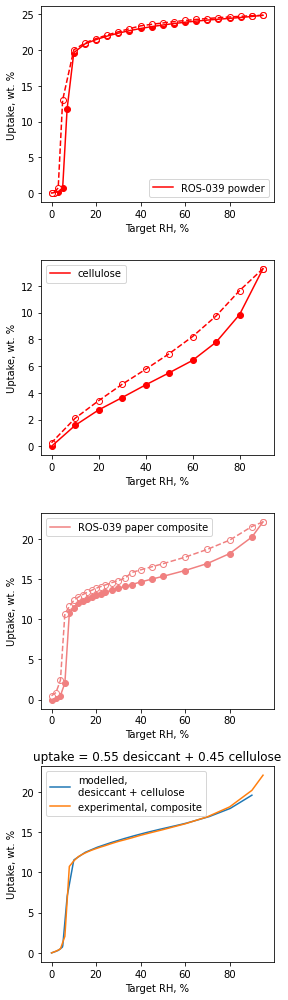

In [6]:
isotherm_data = []
def add_picture_WaterSorption_isotherm(Sorption_list, dpi, width, height):
    fig, ax = plt.subplots(4, 1, figsize=(4, 14))
    
    for m, Sorption in enumerate(Sorption_list):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
            print(m)
            ax[m].plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                     c=name_and_color_dictionary[Sorption.filename]['color'],
                     label=name_and_color_dictionary[Sorption.filename]['name'])
            ax[m].scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                        c=name_and_color_dictionary[Sorption.filename]['color'])
            ax[m].plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                     c=name_and_color_dictionary[Sorption.filename]['color'], 
                     linestyle='dashed')
            ax[m].scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                        facecolors='w', 
                        edgecolors=name_and_color_dictionary[Sorption.filename]['color'])
            ax[m].set_xlabel('Target RH, %')
            ax[m].set_ylabel('Uptake, wt. %')
            ax[m].legend()        
            isotherm_data.append([isotherm_RHtarget_ads, [i for i in isotherm_adsorption]])
    from scipy.optimize import curve_fit
    def func(x, a):
        return a * interpolate_desiccant(x) +  (1-a) * interpolate_cellulose(x)   
    
    from scipy import interpolate
    interpolate_desiccant = interpolate.interp1d(isotherm_data[0][0], isotherm_data[0][1])
    interpolate_cellulose = interpolate.interp1d(isotherm_data[1][0], isotherm_data[1][1])
    interpolate_composite = interpolate.interp1d(isotherm_data[2][0], isotherm_data[2][1])
    popt, pcov = curve_fit(func, np.linspace(0, 90, 500), interpolate_composite(np.linspace(0, 90, 500)), bounds=(0, 1))
    print(popt)
    ax[3].plot(np.linspace(0, 90, 500), func(np.linspace(0, 90, 500), *popt), label = 'modelled,\ndesiccant + cellulose'
              )
    ax[3].plot(isotherm_data[2][0], isotherm_data[2][1], label='experimental, composite')
    ax[3].set_xlabel('Target RH, %')
    ax[3].set_ylabel('Uptake, wt. %')
    ax[3].set_title('uptake = {0:.2f} desiccant + {1:.2f} cellulose'.format(popt[0], 1-popt[0]))
    ax[3].legend()
    plt.tight_layout()
    plt.savefig('Figure_isotherm_ROS039paper_fitting.png', dpi=dpi)
    plt.show()


if Water_Sorption_list !=[]:
    add_picture_WaterSorption_isotherm(Water_Sorption_list,  dpi=300, width=15, height=6)
